# Using Python Libraries (FinQuant, Empyrical) for Portfolio Management

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import requests
from bs4 import BeautifulSoup
import csv
import time
import finquant
from finquant.portfolio import build_portfolio

%load_ext lab_black

## Hypothetical Portfolios

In [2]:
# Using Python Requests library to download historical returns from Yahoo Finace. Other finance APIs are quite restrictive #
## Solution found on StackOverflow ##

import re
from io import StringIO
from datetime import datetime, timedelta


class YahooFinanceHistory:
    timeout = 2
    crumb_link = "https://finance.yahoo.com/quote/{0}/history?p={0}"
    crumble_regex = r'CrumbStore":{"crumb":"(.*?)"}'
    quote_link = "https://query1.finance.yahoo.com/v7/finance/download/{quote}?period1={dfrom}&period2={dto}&interval=1mo&events=history&crumb={crumb}"

    def __init__(self, symbol, days_back=7):
        self.symbol = symbol
        self.session = requests.Session()
        self.dt = timedelta(days=days_back)

    def get_crumb(self):
        response = self.session.get(
            self.crumb_link.format(self.symbol), timeout=self.timeout
        )
        response.raise_for_status()
        match = re.search(self.crumble_regex, response.text)
        if not match:
            raise ValueError("Could not get crumb from Yahoo Finance")
        else:
            self.crumb = match.group(1)

    def get_quote(self):
        if not hasattr(self, "crumb") or len(self.session.cookies) == 0:
            self.get_crumb()
        now = datetime.utcnow()
        dateto = int(now.timestamp())
        datefrom = int((now - self.dt).timestamp())
        url = self.quote_link.format(
            quote=self.symbol, dfrom=datefrom, dto=dateto, crumb=self.crumb
        )
        response = self.session.get(url)
        response.raise_for_status()

        return pd.read_csv(StringIO(response.text), parse_dates=["Date"])

In [3]:
days_back = 365 * 10


def priceDf(tickers):

    new = dict()
    for ticker in tickers:
        data = YahooFinanceHistory(ticker, days_back).get_quote()
        new[ticker] = data["Adj Close"]
        new["Date"] = data["Date"]

    new = pd.DataFrame(data=new)
    new.set_index("Date", inplace=True)
    new.index = pd.to_datetime(new.index).to_period("M")

    return new

In [4]:
ticks = [
    "AAL",
    "AXP",
    "AAPL",
    "BAC",
    "CMCSA",
    "CVS",
    "DAL",
    "MA",
    "NKE",
    "UNH",
    "V",
    "DIS",
    "SPY",
    "XAR",
    "VHT",
    "VB",
    "BND",
    "VTV",
]
rem = ["AAL", "CMCSA", "CVS", "VB"]
add = ["KO", "VGT"]
keep = [t for t in ticks if t not in rem]
hticks1 = keep + add

In [6]:
new1 = priceDf(hticks1)
# hmast1 = pd.concat([hmast1, new1], axis=1)
new1

,AXP,AAPL,BAC,DAL,MA,NKE,UNH,V,DIS,SPY,XAR,VHT,BND,VTV,KO,VGT
Date,,,,,,,,,,,,,,,,
2010-07,38.614384,31.814383,12.465654,10.553022,17.943613,13.902665,26.103277,15.246343,29.344988,90.553703,21.891249,43.697258,61.466763,36.963882,19.096943,47.295860
2010-08,34.488258,30.064436,11.062824,9.291633,17.074158,13.215457,27.191977,14.338008,28.343300,86.480568,24.534058,42.801445,62.423424,35.395241,19.363768,44.022072
2010-09,36.356678,35.091660,11.631063,10.339827,19.281160,15.129810,30.098061,15.538717,28.831081,93.723564,24.234539,46.970470,62.427181,37.818092,20.278593,49.597305
2010-10,35.863628,37.222515,10.174247,12.338504,20.663555,15.608957,31.017849,16.354773,31.470297,97.824875,24.661795,47.874916,62.628151,39.115501,21.573271,52.772968
2010-11,37.562683,38.480263,9.729954,12.151961,20.540718,16.507853,31.422239,15.452919,31.801287,97.824875,25.878263,46.772354,62.197666,38.873127,22.224129,52.273434
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03,85.137077,253.603500,20.949295,28.530001,241.187042,82.534111,248.304443,160.850662,96.599998,256.243225,NaN,165.662292,84.658150,88.270271,43.470375,211.081207
2020-04,90.745918,293.006836,23.883434,25.910000,274.545471,86.963066,292.470001,178.421249,108.150002,290.480011,NaN,188.419998,86.974075,98.559998,45.476849,242.000000
2020-05,95.070000,317.081665,23.952951,25.209999,300.890015,98.334702,304.850006,194.913635,117.300003,304.320007,NaN,196.619995,87.576523,101.400002,46.259735,261.029999


In [309]:
import empyrical as ep

period = "weekly"

for t in add:
    prices = hmast1[t]
    print(t + "\n")
    rets = ep.simple_returns(prices)
    print(ep.cagr(rets, period))
    print(ep.sharpe_ratio(prices, risk_free=0.02, period=period))
    print("\n")

KO

0.47164180188845406
30.86012125283905


VGT

1.1372323664221624
14.137799135868159




In [9]:
hpf1 = build_portfolio(data=new1)

In [278]:
h1_ms = hpf1.ef_maximum_sharpe_ratio(verbose=False)
h1_ms

,Allocation
AXP,0.000000
AAPL,0.006621
BAC,0.000000
DAL,0.000000
MA,0.070716
NKE,0.036897
UNH,0.093287
V,0.035154
DIS,0.000000
SPY,0.000000


In [439]:
hpf1.comp_weights()

0    0.062500
1    0.062500
2    0.062500
3    0.062500
4    0.062500
5    0.062500
6    0.062500
7    0.062500
8    0.062500
9    0.062500
10   0.062500
11   0.062500
12   0.062500
13   0.062500
14   0.062500
15   0.062500
Name: Allocation, dtype: float64

In [380]:
hpf1.ef_maximum_sharpe_ratio()

,Allocation
AXP,0.000000
AAPL,0.006621
BAC,0.000000
DAL,0.000000
MA,0.070716
NKE,0.036897
UNH,0.093287
V,0.035154
DIS,0.000000
SPY,0.000000


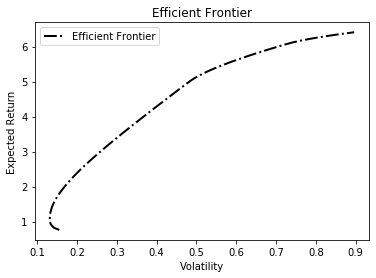

In [14]:
hpf1.ef_plot_efrontier()
plt.savefig("../../docs/assets/img/ivst-1.png", dpi=100, bbox_inches="tight")

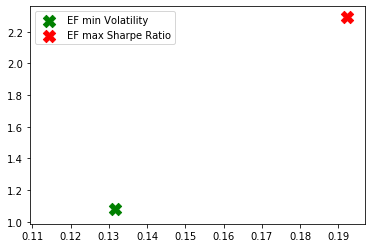

In [11]:
hpf1.ef_plot_optimal_portfolios()

### All ETFs

In [483]:
hticks2 = [
    "SPY",
    "XAR",
    "VHT",
    "BND",
    "VTV",
    "VGT",
    "XLE",
    "AAPL",
    "UNH",
    "MA",
    "V",
    "NKE",
]
ticks = list(ticks)
rem = [t for t in ticks if t not in hticks2]
add = [t for t in hticks2 if t not in ticks]
keep = [t for t in hticks2 if t in ticks]

In [497]:
hmast2 = pd.concat([master.loc[:, keep], priceDf(add)], axis=1)

In [498]:
hmast2

,SPY,XAR,VHT,BND,VTV,AAPL,UNH,MA,V,NKE,VGT,XLE
Date,,,,,,,,,,,,
2010-07,90.553703,21.891249,43.697258,61.466763,36.963882,31.814383,26.103277,17.943613,15.246343,13.902665,47.295860,40.431011
2010-08,86.480568,24.534058,42.801445,62.423424,35.395241,30.064436,27.191977,17.074158,14.338008,13.215457,44.022072,38.448498
2010-09,93.723564,24.234539,46.970470,62.427181,37.818092,35.091660,30.098061,19.281160,15.538717,15.129810,49.597305,42.098106
2010-10,97.824875,24.661795,47.874916,62.628151,39.115501,37.222515,31.017849,20.663555,16.354773,15.608957,52.772968,44.690636
2010-11,97.824875,25.878263,46.772354,62.197666,38.873127,38.480263,31.422239,20.540718,15.452919,16.507853,52.273434,47.308418
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03,256.243225,nan,165.662292,84.658150,88.270271,253.603500,248.304443,241.187042,160.850662,82.534111,211.081207,28.423962
2020-04,290.480011,nan,188.419998,86.974075,98.559998,293.006836,292.470001,274.545471,178.421249,86.963066,242.000000,38.000000
2020-05,304.320007,nan,196.619995,87.576523,101.400002,317.081665,304.850006,300.890015,194.913635,98.334702,261.029999,38.759998


In [499]:
hpf2 = build_portfolio(data=hmast2)

In [411]:
def stats(pf):
    vol = pf.comp_volatility()
    sha = pf.comp_sharpe()
    ret = pf.comp_expected_return(freq=12)

    print("volatility = {:f}\n".format(vol))
    print("sharpe = {:f}\n".format(sha))
    print("return = {:f}\n".format(ret))

In [500]:
stats(hpf2)

volatility = 0.526523

sharpe = 7.147451

return = 0.179443



In [501]:
stats(hpf1)

volatility = 0.561281

sharpe = 0.302465

return = 0.174768



In [502]:
stats(pf)

volatility = 0.730285

sharpe = 4.589820

return = 0.159851



US Fundamental API token: Ph8tWMmdILCKi5oEz-Uelw

## New ETFs

In [503]:
add = ["VEA", "VWO"]
keep = hticks2
hticks3 = keep + add

In [506]:
new3 = priceDf(add)

In [516]:
hmast3

,SPY,XAR,VHT,BND,VTV,AAPL,UNH,MA,V,NKE,VGT,XLE,VEA,VWO
Date,,,,,,,,,,,,,,
2010-07,90.553703,21.891249,43.697258,61.466763,36.963882,31.814383,26.103277,17.943613,15.246343,13.902665,47.295860,40.431011,24.025383,32.257786
2010-08,86.480568,24.534058,42.801445,62.423424,35.395241,30.064436,27.191977,17.074158,14.338008,13.215457,44.022072,38.448498,23.164440,31.433432
2010-09,93.723564,24.234539,46.970470,62.427181,37.818092,35.091660,30.098061,19.281160,15.538717,15.129810,49.597305,42.098106,25.401407,35.023609
2010-10,97.824875,24.661795,47.874916,62.628151,39.115501,37.222515,31.017849,20.663555,16.354773,15.608957,52.772968,44.690636,26.431602,36.109917
2010-11,97.824875,25.878263,46.772354,62.197666,38.873127,38.480263,31.422239,20.540718,15.452919,16.507853,52.273434,47.308418,25.136505,35.085243
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03,256.243225,nan,165.662292,84.658150,88.270271,253.603500,248.304443,241.187042,160.850662,82.534111,211.081207,28.423962,33.191494,33.487469
2020-04,290.480011,nan,188.419998,86.974075,98.559998,293.006836,292.470001,274.545471,178.421249,86.963066,242.000000,38.000000,35.680000,36.169998
2020-05,304.320007,nan,196.619995,87.576523,101.400002,317.081665,304.850006,300.890015,194.913635,98.334702,261.029999,38.759998,37.669998,37.360001


In [ ]:
hmast3.drop()

In [520]:
hpf3 = build_portfolio(data=hmast3.drop(columns=["VEA", "VWO"]))

In [521]:
stats(hpf3)

volatility = 0.526523

sharpe = 7.147451

return = 0.179443



## Fundamentals

In [17]:
import os
from dotenv import load_dotenv
from pathlib import Path

env_path = Path("..") / ".env"
load_dotenv(dotenv_path=env_path)
usf_token = os.getenv("usf_token")

In [19]:
cik_dict = dict(aapl="0000320193")